In [3]:
# Implementation from https://github.com/dougalsutherland/opt-mmd

import sys, os
import numpy as np
from math import sqrt

CHANNEL_MEANS = (129.30402159690857/255, 124.06998485326767/255, 112.43405923247337/255)
CHANNEL_STDS = (68.17022681236267/255, 65.3918083012104/255, 70.41839897632599/255)

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

def kernelwidth(X, Y):
    X = np.concatenate((X, Y), axis=0)
    res = euclidean_distances(X, X)
    return np.median(res)

In [5]:
def rbf_mmd2(X, Y, sigma=0, biased=True):
    gamma = 1 / (2 * sigma**2)
    
    XX = np.dot(X, X.T)
    XY = np.dot(X, Y.T)
    YY = np.dot(Y, Y.T)
    
    X_sqnorms = np.diag(XX)
    Y_sqnorms = np.diag(YY)
    
    K_XY = np.exp(-gamma * (
        -2 * XY + X_sqnorms[:, np.newaxis] + Y_sqnorms[np.newaxis, :]))
    K_XX = np.exp(-gamma * (
        -2 * XX + X_sqnorms[:, np.newaxis] + X_sqnorms[np.newaxis, :]))
    K_YY = np.exp(-gamma * (
        -2 * YY + Y_sqnorms[:, np.newaxis] + Y_sqnorms[np.newaxis, :]))
    
    if biased:
        mmd2 = K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()
    else:
        m = K_XX.shape[0]
        n = K_YY.shape[0]

        mmd2 = ((K_XX.sum() - m) / (m * (m - 1))
              + (K_YY.sum() - n) / (n * (n - 1))
              - 2 * K_XY.mean())
    return mmd2

In [6]:
from PIL import Image
from matplotlib import pyplot as plt

def display_sample(sample):
    img = sample.reshape((28, 28)) * 255.
    plt.imshow(Image.fromarray(img))
    plt.show()

In [7]:
# Add Bayesian-and-novelty directory to the PYTHONPATH
import sys
import os
sys.path.append(os.path.realpath('../../../..'))

# Autoreload changes in utils, etc.
%load_ext autoreload
%autoreload 2

import torch
from torchvision import datasets, transforms
import numpy as np
from functools import reduce

from novelty.utils.datasets import GaussianNoiseDataset
from novelty.utils.datasets import UniformNoiseDataset
from novelty.utils import DatasetSubset


torch.manual_seed(1)

# CIFAR100

In [6]:
def get_cifar100_test_data(cifar100_dir):
    """
    Return flattened and scaled CIFAR100 test data as a numpy array.
    
    Saves/loads dataset from cifar100_dir.
    """
    print("Loading CIFAR100 test")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
    ])
    
    dataset = datasets.CIFAR100(cifar100_dir, train=False, download=True, transform=transform)
    dataset = np.array([a[0].numpy() for a in dataset])
    dataset = dataset.astype('float32')
    return dataset.reshape(dataset.shape[0], reduce(lambda s, x: s * x, dataset.shape[1:], 1))

cifar100_test = get_cifar100_test_data('/media/tadenoud/DATADisk/datasets/cifar100/')

Loading CIFAR100 test
Files already downloaded and verified


In [7]:
def get_imagenet_crop_data(imagenet_dir):
    """
    Return cropped, flattened, and scaled TinyImageNet test data as a numpy array.
    
    Saves/loads dataset from imagenet_dir.
    """
    print("Loading ImageNet crop")
    
    transform_crop = transforms.Compose([
        transforms.RandomCrop([32, 32]),
        transforms.ToTensor(),
        transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
    ])

    dataset = datasets.ImageFolder(imagenet_dir, transform=transform_crop)
    dataset = np.array([a[0].numpy() for a in dataset])
    dataset = dataset.astype('float32')
    return dataset.reshape(dataset.shape[0],  reduce(lambda s, x: s * x, dataset.shape[1:], 1))

imagenet_crop = get_imagenet_crop_data('/media/tadenoud/DATADisk/datasets/tiny-imagenet-200/test/')

imagenet_crop_sigma = kernelwidth(cifar100_test, imagenet_crop)
imagenet_crop_mmd = rbf_mmd2(cifar100_test, imagenet_crop, sigma=imagenet_crop_sigma)
print("Imagenet (crop) MMD:", imagenet_crop_mmd)

Loading ImageNet crop
Imagenet (crop) MMD: 0.010746359825134277


In [8]:
def get_imagenet_resize_data(imagenet_dir):
    """
    Return resized, flattened, and scaled TinyImageNet test data as a numpy array.
    
    Saves/loads dataset from imagenet_dir.
    """
    print("Loading ImageNet resize")
    
    transform_resize = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
    ])

    dataset = datasets.ImageFolder(imagenet_dir, transform=transform_resize)
    dataset = np.array([a[0].numpy() for a in dataset])
    dataset = dataset.astype('float32')
    return dataset.reshape(dataset.shape[0],  reduce(lambda s, x: s * x, dataset.shape[1:], 1))

imagenet_resize = get_imagenet_resize_data('/media/tadenoud/DATADisk/datasets/tiny-imagenet-200/test/')

imagenet_resize_sigma = kernelwidth(cifar100_test, imagenet_resize)
imagenet_resize_mmd = rbf_mmd2(cifar100_test, imagenet_resize, sigma=imagenet_resize_sigma)
print("Imagenet (resize) MMD:", imagenet_resize_mmd)

Loading ImageNet resize
Imagenet (resize) MMD: 0.007992982864379883


In [9]:
def get_lsun_crop_data(lsun_dir):
    """
    Return cropped, flattened, and scaled LSUN test data as a numpy array.
    
    Saves/loads dataset from lsun_dir.
    """
    print("Loading LSUN crop")
    
    transform_crop = transforms.Compose([
        transforms.RandomCrop([32, 32]),
        transforms.ToTensor(),
        transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
    ])
    
    dataset = datasets.LSUN(lsun_dir, classes='test', transform=transform_crop)
    dataset = np.array([a[0].numpy() for a in dataset])
    dataset = dataset.astype('float32')
    return dataset.reshape(dataset.shape[0],  reduce(lambda s, x: s * x, dataset.shape[1:], 1))

lsun_crop = get_lsun_crop_data('/media/tadenoud/DATADisk/datasets/lsun/')

lsun_crop_sigma = kernelwidth(cifar100_test, lsun_crop)
lsun_crop_mmd = rbf_mmd2(cifar100_test, lsun_crop, sigma=lsun_crop_sigma)
print("LSUN (crop) MMD:", lsun_crop_mmd)

Loading LSUN crop
LSUN (crop) MMD: 0.015182018280029297


In [10]:
def get_lsun_resize_data(lsun_dir):
    """
    Return resized, flattened, and scaled LSUN test data as a numpy array.
    
    Saves/loads dataset from lsun_dir.
    """
    print("Loading LSUN resize")
    
    transform_resize = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
    ])
    
    dataset = datasets.LSUN(lsun_dir, classes='test', transform=transform_resize)
    dataset = np.array([a[0].numpy() for a in dataset])
    dataset = dataset.astype('float32')
    return dataset.reshape(dataset.shape[0],  reduce(lambda s, x: s * x, dataset.shape[1:], 1))

lsun_resize = get_lsun_resize_data('/media/tadenoud/DATADisk/datasets/lsun/')

lsun_resize_sigma = kernelwidth(cifar100_test, lsun_resize)
lsun_resize_mmd = rbf_mmd2(cifar100_test, lsun_resize, sigma=lsun_resize_sigma)
print("LSUN (resize) MMD:", lsun_resize_mmd)

Loading LSUN resize
LSUN (resize) MMD: 0.013692021369934082


In [11]:
def get_isun_data(isun_dir):
    """
    Return flattened, and scaled iSUN test data as a numpy array.
    
    Saves/loads dataset from isun_dir.
    """
    print("Loading iSUN")
    
    transform_resize = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
    ])

    dataset = datasets.ImageFolder(isun_dir, transform=transform_resize)
    dataset = np.array([a[0].numpy() for a in dataset])
    dataset = dataset.astype('float32')
    return dataset.reshape(dataset.shape[0],  reduce(lambda s, x: s * x, dataset.shape[1:], 1))

isun_data = get_isun_data('/media/tadenoud/DATADisk/datasets/isun/')

isun_sigma = kernelwidth(cifar100_test, isun_data)
isun_mmd = rbf_mmd2(cifar100_test, isun_data, sigma=isun_sigma)
print("iSUN MMD:", isun_mmd)

Loading iSUN
iSUN MMD: 0.009173035621643066


In [12]:
def get_gaussian_test_data():
    """Return flattened, and scaled Gaussian Noise test data as a numpy array."""
    print("Loading Gaussian Noise data")
    
    dataset = GaussianNoiseDataset((10000, 32*32*3), mean=0.0, std=1)
    dataset = np.array([a for a, _ in iter(dataset)])
    return dataset.astype('float32')

gaussianTestX = get_gaussian_test_data()

gaussian_sigma = kernelwidth(cifar100_test, gaussianTestX)
gaussian_mmd = rbf_mmd2(cifar100_test, gaussianTestX, sigma=gaussian_sigma)
print("Gaussian MMD:", gaussian_mmd)

Loading Gaussian Noise data
Gaussian MMD: 0.012980461120605469


In [13]:
import math

def get_uniform_test_data():
    """Return flattened, and scaled Uniform Noise test data as a numpy array."""
    print("Loading Uniform Noise data")
    
    dataset = UniformNoiseDataset((10000, 32*32*3), low=-math.sqrt(3), high=math.sqrt(3))
    dataset = np.array([a for a, _ in iter(dataset)])
    return dataset.astype('float32')

uniformTestX = get_uniform_test_data()

uniform_sigma = kernelwidth(cifar100_test, uniformTestX)
uniform_mmd = rbf_mmd2(cifar100_test, uniformTestX, sigma=uniform_sigma)
print("Uniform MMD:", uniform_mmd)

Loading Uniform Noise data
Uniform MMD: 0.06342089176177979


# CIFAR100 results

,mmd,sigma
imagenet_resize,0.00799298,70.79
isun_resize,0.00917304,73.2132
imagenet_crop,0.0107464,73.8949
gaussian,0.0129805,77.6721
lsun_resize,0.013692,70.8034
lsun_crop,0.015182,72.9875
uniform,0.0634209,58.0288


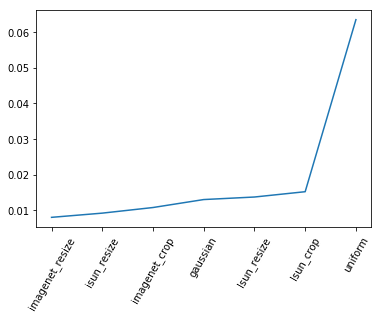

In [14]:
import pandas as pd
from IPython.display import display

df = pd.DataFrame(columns=['mmd', 'sigma'],
                  index=['imagenet_crop', 'imagenet_resize', 'lsun_crop', 'lsun_resize', 
                         'isun_resize', 'gaussian', 'uniform'])

df.loc['imagenet_crop'] = pd.Series({'mmd': imagenet_crop_mmd, 'sigma': imagenet_crop_sigma})
df.loc['imagenet_resize'] = pd.Series({'mmd': imagenet_resize_mmd, 'sigma': imagenet_resize_sigma})
df.loc['lsun_crop'] = pd.Series({'mmd': lsun_crop_mmd, 'sigma': lsun_crop_sigma})
df.loc['lsun_resize'] = pd.Series({'mmd': lsun_resize_mmd, 'sigma': lsun_resize_sigma})
df.loc['isun_resize'] = pd.Series({'mmd': isun_mmd, 'sigma': isun_sigma})
df.loc['gaussian'] = pd.Series({'mmd': gaussian_mmd, 'sigma': gaussian_sigma})
df.loc['uniform'] = pd.Series({'mmd': uniform_mmd, 'sigma': uniform_sigma})

df = df.sort_values(by=['mmd'])

display(df)

#plt.plot(df['mmd'])
#plt.xticks(rotation=60)
#plt.show()

In [15]:
df.to_pickle('../results/cifar100_mmd.pkl')

# Calculate mean and standard deviation normalization values per channel

In [8]:
CHANNEL_MEANS = (129.30402159690857/255, 124.06998485326767/255, 112.43405923247337/255)
CHANNEL_STDS = (68.17022681236267/255, 65.3918083012104/255, 70.41839897632599/255)


def _get_cifar100(cifar100_dir):
    """
    Return scaled CIFAR100 test data as a numpy array.
    
    Saves/loads dataset from cifar100_dir.
    """
    print("Loading CIFAR100 train")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
    ])
    
    dataset = datasets.CIFAR100(cifar100_dir, train=True, download=True, transform=transform)
    dataset = np.array([a[0].numpy() for a in dataset])
    return dataset.astype('float32')

data = _get_cifar100('/media/tadenoud/DATADisk/datasets/cifar100/')

Loading CIFAR100 train
Files already downloaded and verified


In [9]:
means = []
for i in range(3):
    val = np.reshape(data[:,i,:,:], -1)
    mean = np.mean(val)
    print('mean (%d): %f' % (i, mean))
    means.append(mean*255)

print()

stds = []
for i in range(3):
    val = np.reshape(data[:,i,:,:], -1)
    std = np.std(val)
    print('std (%d): %f' % (i, std))
    stds.append(std*255)

print()
print('CHANNEL_MEANS = ({}/255, {}/255, {}/255)'.format(*means))
print('CHANNEL_STDS = ({}/255, {}/255, {}/255)'.format(*stds))

mean (0): 0.507075
mean (1): 0.486549
mean (2): 0.440918

std (0): 0.267334
std (1): 0.256438
std (2): 0.276151

CHANNEL_MEANS = (129.30402159690857/255, 124.06998485326767/255, 112.43405923247337/255)
CHANNEL_STDS = (68.17022681236267/255, 65.3918083012104/255, 70.41839897632599/255)
